# Plot Comparisons

`comparisons` and `plot_comparisons` are a part of Bambi's sub-package `interpret` that features a set of functions used to interpret complex regression models. This sub-package is inspired by the R package [marginaleffects](https://marginaleffects.com/chapters/predictions.html#conditional-predictions). These two functions allow the modeler to **compare** the predictions made by a model for different contrast and covariate values. Below, it is described why comparing predictions is useful in interpreting generalized linear models (GLMs), how this methodology is implemented in Bambi, and how to use `comparisons` and `plot_comparisons`. It is assumed that the reader is familiar with the basics of GLMs. If not, refer to the Bambi [Basic Building Blocks](https://bambinos.github.io/bambi/notebooks/how_bambi_works.html#Link-functions) example.

Due to the link function in a GLM, there are typically three quantities of interest to interpret:

1. the linear predictor $\eta = X\beta$ where $X$ is an $n$ x $p$ matrix of explanatory variables.
2. the mean $\mu = g^{-1}(\eta)$ where the link function $g(\cdot)$ relates the linear predictor to the mean of the outcome variable $\mu = g^{-1}(\eta) = g^{-1}(X\beta)$
3. the response variable $Y \sim \mathcal{D}(\mu, \theta)$ where $\mu$ is the mean parameter and $\theta$ is (possibly) a vector that contains all the other "auxiliary" parameters of the distribution.
 
Often, with GLMs, $\eta$ is linear in the parameters, but nonlinear in relation of inputs to the outcome $Y$ due to the link function $g$. Thus, as modelers, we are usually more interested in interpreting (2) and (3). For example, in logistic regression, the linear predictor is on the log-odds scale, but the quantity of interest is on the probability scale. In Poisson regression, the linear predictor is on the log-scale, but the response variable is on the count scale. Referring back to logistic regression, a specified difference in one of the $x$ variables does _not_ correspond to a constant difference in the the probability of the outcome.

It is often helpful with GLMs, for the modeler and audience, to have a summary that gives the expected difference in the outcome corresponding to a unit difference in each of the input variables. Thus, the goal of `comparisons` and `plot_comparisons` is to provide the modeler with a summary and visualization of the average predicted difference.

## Average Predictive Differences

Here, we adopt the notation from Chapter 14.4 of [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/) to describe average predictive differences. Assume we have fit a Bambi model predicting an outcome $Y$ based on inputs $X$ and parameters $\theta$. Consider the following scalar inputs:

$$w: \text{the input of interest}$$
$$c: \text{all the other inputs}$$
$$X = (w, c)$$

Suppose for the input of interest, we are interested in comparing $w^{\text{high}}$ to $w^{\text{low}}$ (perhaps age = $60$ and $40$ respectively) with all other inputs $c$ held constant. The _predictive difference_ in the outcome changing **only** $w$ is:

$$\text{average predictive difference} = \mathbb{E}(y|w^{\text{high}}, c, \theta) - \mathbb{E}(y|w^{\text{low}}, c, \theta)$$

Selecting the maximum and minimum values of $w$ and averaging over all other inputs $c$ in the data gives you a new "hypothetical" dataset and corresponds to counting all pairs of transitions of $(w^\text{low})$ to $(w^\text{high})$, i.e., differences in $w$ with $c$ held constant. The difference between these two terms is the average predictive difference.

### Computing Average Predictive Differences

The objective of `comparisons` and `plot_comparisons` is to compute the expected difference in the outcome corresponding to three different scenarios for $w$ and $c$ where $w$ is either provided by the user, else a default value is computed by Bambi (described in the default values section). The three scenarios are:

1. user provided values for $c$.
2. a grid of equally spaced and central values for $c$.
3. empirical distribution (original data used to fit the model) for $c$. 

In the case of (1) and (2) above, Bambi assembles all pairwise combinations (transitions) of $w$ and $c$ into a new "hypothetical" dataset. In (3), Bambi uses the original $c$, but replaces $w$ with the user provided value or the default value computed by Bambi. In each scenario, predictions are made on the data using the fitted model. Once the predictions are made, comparisons are computed using the posterior samples by taking the difference in the predicted outcome for each pair of transitions. The average of these differences is the average predictive difference. 

Thus, the goal of `comparisons` and `plot_comparisons` is to provide the modeler with a summary and visualization of the average predictive difference. Below, we demonstrate how to compute and plot average predictive differences with `comparisons` and `plot_comparions` using several examples.

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import warnings

import bambi as bmb

warnings.simplefilter(action="ignore", category=FutureWarning)

## Zero Inflated Poisson

We model and predict how many fish are caught by visitors at a state park using survey [data](https://stats.idre.ucla.edu/stat/data/fish.csv). Many visitors catch zero fish, either because they did not fish at all, or because they were unlucky. We would like to explicitly model this bimodal behavior (zero versus non-zero) using a Zero Inflated Poisson model, and to compare how different inputs of interest $w$ and other covariate values $c$ are associated with the number of fish caught. The dataset contains data on 250 groups that went to a state park to fish. Each group was questioned about how many fish they caught (`count`), how many children were in the group (`child`), how many people were in the group (`persons`), if they used a live bait and whether or not they brought a camper to the park (`camper`).

In [2]:
fish_data = pd.read_csv("https://stats.idre.ucla.edu/stat/data/fish.csv")
cols = ["count", "livebait", "camper", "persons", "child"]
fish_data = fish_data[cols]
fish_data["child"] = fish_data["child"].astype(int)
fish_data["livebait"] = pd.Categorical(fish_data["livebait"])
fish_data["camper"] = pd.Categorical(fish_data["camper"])

In [3]:
fish_model = bmb.Model(
    "count ~ livebait + camper + persons + child", 
    fish_data, 
    family="zero_inflated_poisson"
)

fish_idata = fish_model.fit(
    draws=1000, 
    target_accept=0.95, 
    random_seed=1234, 
    chains=4
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, Intercept, livebait, camper, persons, child]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


### User Provided Values

First, an example of scenario 1 (user provided values) is given below. In both `plot_comparisons` and `comparisons`, $w$ and $c$ are represented by `contrast` and `conditional`, respectively. The modeler has the ability to pass their own values for `contrast` and `conditional` by using a dictionary where the key-value pairs are the covariate and value(s) of interest. For example, if we wanted to compare the number of fish caught for $4$ versus $1$ `persons` conditional on a range of `child` and `livebait` values, we would pass the following dictionary in the code block below. By default, for $w$, Bambi compares $w^\text{high}$ to $w^\text{low}$. Thus, in this example, $w^\text{high}$ = 4 and $w^\text{low}$ = 1. The user is not limited to passing a list for the values. A `np.array` can also be used. Furthermore, Bambi by default, maps the order of the dict keys to the main, group, and panel of the matplotlib figure. Below, since `child` is the first key, this is used for the x-axis, and `livebait` is used for the group (color). If a third key was passed, it would be used for the panel (facet).

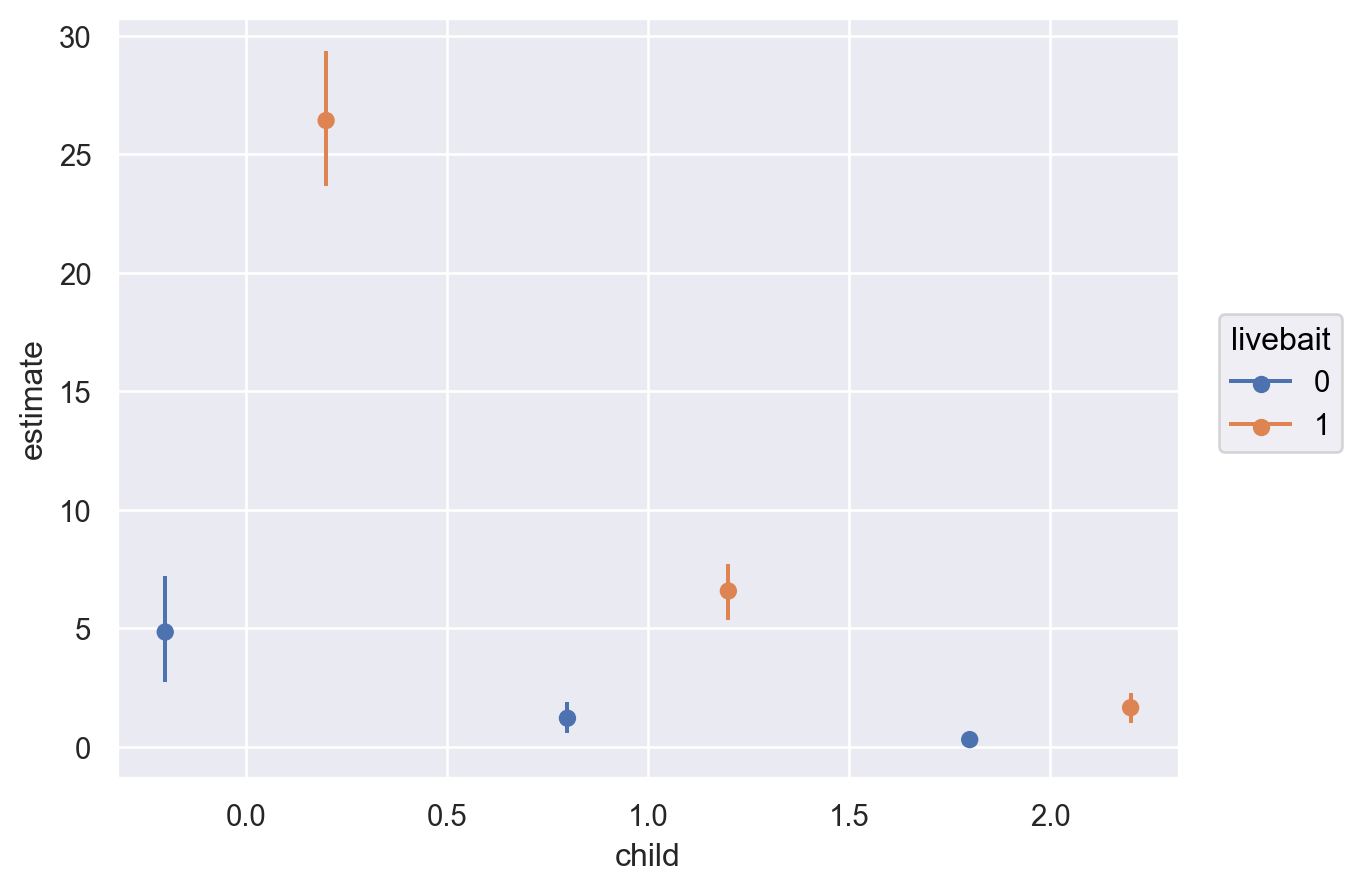

In [4]:
bmb.interpret.plot_comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast={"persons": [1, 4]},
    conditional={"child": [0, 1, 2], "livebait": [0, 1]},
)

The plot above shows that, comparing $4$ to $1$ persons given $0$ children and using livebait, the expected difference is about $26$ fish. When not using livebait, the expected difference decreases substantially to about $5$ fish. Using livebait with a group of people is associated with a much larger expected difference in the number of fish caught. 

`comparisons` can be called to view a summary dataframe that includes the term $w$ and its contrast, the specified `conditional` covariate, and the expected difference in the outcome with the uncertainty interval (by default the 94% highest density interval is computed). 

`comparisons` returns a `Result` named tuple with two fields: `summary` and `draws`. The `summary` field is a pandas DataFrame containing the point estimates (posterior mean) and credible intervals for each row of the comparison grid. The `draws` field is an `arviz.InferenceData` object containing the full posterior samples used to compute the summary. The `summary` is useful for quick inspection and tabular reporting, while `draws` gives access to the complete posterior distribution for custom analyses or visualizations beyond the default summary statistics.

In [5]:
bmb.interpret.comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast={"persons": [1, 4]},
    conditional={"child": [0, 1, 2], "livebait": [0, 1]},
).summary

,term,estimate_type,child,livebait,camper,value,estimate,lower_3.0%,upper_97.0%
0,persons,diff,0,0,1,1_vs_4,4.842881,2.821815,7.115986
1,persons,diff,0,1,1,1_vs_4,26.425842,23.755334,29.280517
2,persons,diff,1,0,1,1_vs_4,1.206022,0.677176,1.803814
3,persons,diff,1,1,1,1_vs_4,6.573751,5.423433,7.621986
4,persons,diff,2,0,1,1_vs_4,0.303025,0.148255,0.478763
5,persons,diff,2,1,1,1_vs_4,1.649977,1.103601,2.187071


But why is `camper` also in the summary dataframe? This is because in order to peform predictions, Bambi is expecting a value for each covariate used to fit the model. Additionally, with GLM models, average predictive comparisons are conditional in the sense that the estimate depends on the values of all the covariates in the model. Thus, for unspecified covariates, `comparisons` and `plot_comparisons` computes a default value (mean or mode based on the data type of the covariate). Thus, $c$ = `child`, `livebait`, `camper`. Each row in the summary dataframe is read as "comparing $4$ to $1$ persons conditional on $c$, the expected difference in the outcome is $y$."

### Multiple contrast values

Users can also perform comparisons on multiple contrast values. For example, if we wanted to compare the number of fish caught between $(1, 2)$, $(1, 4)$, and $(2, 4)$ `persons` conditional on a range of values for `child` and `livebait`.

In [6]:
multiple_values = bmb.interpret.comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast={"persons": [1, 2, 4]},
    conditional={"child": [0, 1, 2], "livebait": [0, 1]}
)

multiple_values.summary

,term,estimate_type,child,livebait,camper,value,estimate,lower_3.0%,upper_97.0%
0,persons,diff,0,0,1,1_vs_2,0.529259,0.321399,0.791332
0,persons,diff,0,0,1,1_vs_4,4.842881,2.821815,7.115986
0,persons,diff,0,0,1,2_vs_4,4.313622,2.382278,6.241083
1,persons,diff,0,1,1,1_vs_2,2.888830,2.579503,3.162645
1,persons,diff,0,1,1,1_vs_4,26.425842,23.755334,29.280517
1,persons,diff,0,1,1,2_vs_4,23.537012,20.853632,26.310769
2,persons,diff,1,0,1,1_vs_2,0.131938,0.069623,0.196654
2,persons,diff,1,0,1,1_vs_4,1.206022,0.677176,1.803814
2,persons,diff,1,0,1,2_vs_4,1.074084,0.606115,1.614813
3,persons,diff,1,1,1,1_vs_2,0.719383,0.590442,0.860085


Notice how the contrast $w$ varies while the covariates $c$ are held constant. Currently, however, plotting multiple contrast values can be difficult to interpret since the contrast is "abstracted" away onto the y-axis. Thus, it would be difficult to interpret which portion of the plot corresponds to which contrast value. Therefore, it is currently recommended that if you want to plot multiple contrast values, call `comparisons` directly to obtain the summary dataframe and plot the results yourself.

### Default contrast and conditional values

Now, we move onto scenario 2 described above (grid of equally spaced and central values) in computing average predictive comparisons. You are not required to pass values for `contrast` and `conditional`. If you do not pass values, Bambi will compute default values for you. Below, it is described how these default values are computed.

The default value for `contrast` is a _centered difference_ at the mean for a contrast variable with a numeric dtype, and _unique levels_ for a contrast varaible with a categorical dtype. For example, if the modeler is interested in the comparison of a $5$ unit increase in $w$ where $w$ is a numeric variable, Bambi computes the mean and then subtracts and adds $2.5$ units to the mean to obtain a _centered difference_. By default, if no value is passed for the contrast covariate, Bambi computes a one unit centered difference at the mean. For example, if only `contrast="persons"` is passed, then $\pm$ $0.5$ is applied to the mean of persons. If $w$ is a categorical variable, Bambi computes and returns the unique levels. For example, if $w$ has levels ["high scool", "vocational", "university"], Bambi computes and returns the unique values of this variable.

The default values for `conditional` are more involved. Currently, by default, if a dict or list is passed to `conditional`, Bambi uses the ordering (keys if dict and elements if list) to determine which covariate to use as the main, group (color), and panel (facet) variable. This is the same logic used in `plot_comparisons` described above. Subsequently, the default values used for the `conditional` covariates depend on their ordering **and** dtype. Below, the psuedocode used for computing default values covariates passed to `conditional` is outlined:

```python
if v == "main":
    
    if v == numeric:
        return np.linspace(v.min(), v.max(), 50)
    elif v == categorical:
        return np.unique(v)

elif v == "group":
    
    if v == numeric:
        return np.quantile(v, np.linspace(0, 1, 5))
    elif v == categorical:
        return np.unique(v)

elif v == "panel":
    
    if v == numeric:
        return np.quantile(v, np.linspace(0, 1, 5))
    elif v == categorical:
        return np.unique(v)
```

Thus, letting Bambi compute default values for `conditional` is equivalent to creating a hypothetical "data grid" of new values. Let's say we are interested in comparing the number of fish caught for the contrast `livebait` conditional on `persons` and `child`. This time, let's call `comparisons` first to gain an understanding of the data generating the plot.

In [7]:
contrast_df = bmb.interpret.comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=["persons", "child"],
)

contrast_df.summary.head(10)

,term,estimate_type,persons,child,camper,value,estimate,lower_3.0%,upper_97.0%
0,livebait,diff,1,0,1,0_vs_1,1.701079,1.277529,2.120203
1,livebait,diff,1,1,1,0_vs_1,0.424020,0.294745,0.551709
2,livebait,diff,1,2,1,0_vs_1,0.106643,0.065813,0.155744
3,livebait,diff,1,3,1,0_vs_1,0.027060,0.012615,0.043123
4,livebait,diff,2,0,1,0_vs_1,4.060650,3.318717,4.815739
5,livebait,diff,2,1,1,0_vs_1,1.011465,0.765103,1.259941
6,livebait,diff,2,2,1,0_vs_1,0.254208,0.162271,0.355378
7,livebait,diff,2,3,1,0_vs_1,0.064458,0.031792,0.100255
8,livebait,diff,4,0,1,0_vs_1,23.284040,19.752637,26.390713
9,livebait,diff,4,1,1,0_vs_1,5.791750,4.693049,6.940059


As `livebait` was encoded as a categorical dtype, Bambi returned the unique levels of $[0, 1]$ for the contrast. `persons` and `child` were passed as the first and second element and thus act as the main and group variables, respectively. It can be see from the output above, that an equally spaced grid was used to compute the values for `persons`, whereas a quantile based grid was used for `child`. Furthermore, as `camper` was unspecified, the mode was used as the default value. Let's go ahead and plot the comparisons.

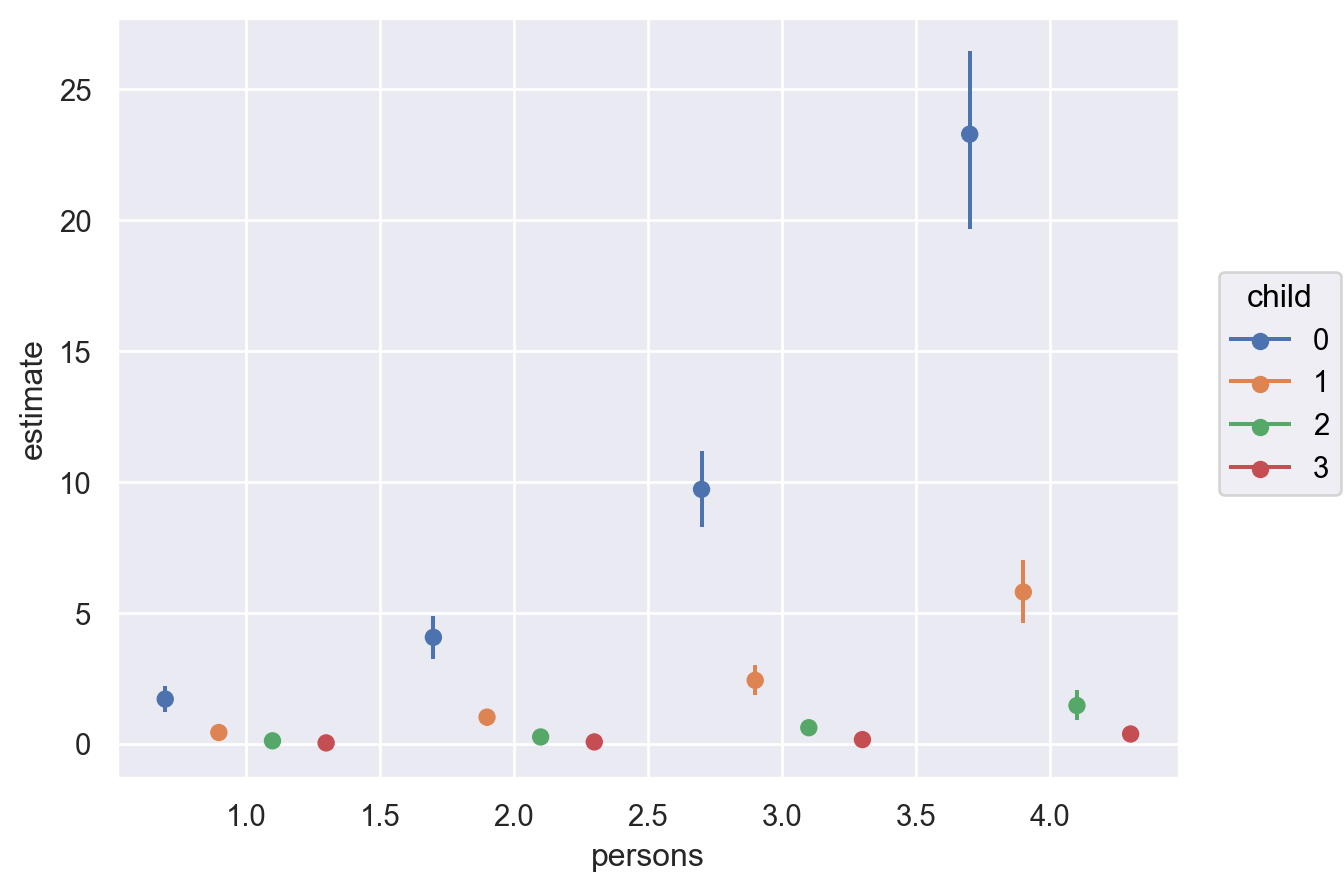

In [8]:
bmb.interpret.plot_comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=["persons", "child"],
)

The plot shows us that the expected differences in fish caught comparing a group of people who use livebait and no livebait is not only conditional on the number of persons, but also children. However, the plotted comparisons for `child` = $3$ is difficult to interpret on a single plot. Thus, it can be useful to pass specific `group` and `panel` arguments to aid in the interpretation of the plot. Therefore, `subplot_kwargs` allows the user to manipulate the plotting by passing a dictionary where the keys are `{"main": ..., "group": ..., "panel": ...}` and the values are the names of the covariates to be plotted. Below, we plot the same comparisons as above, but this time we specify `group` and `panel` to both be `child`.

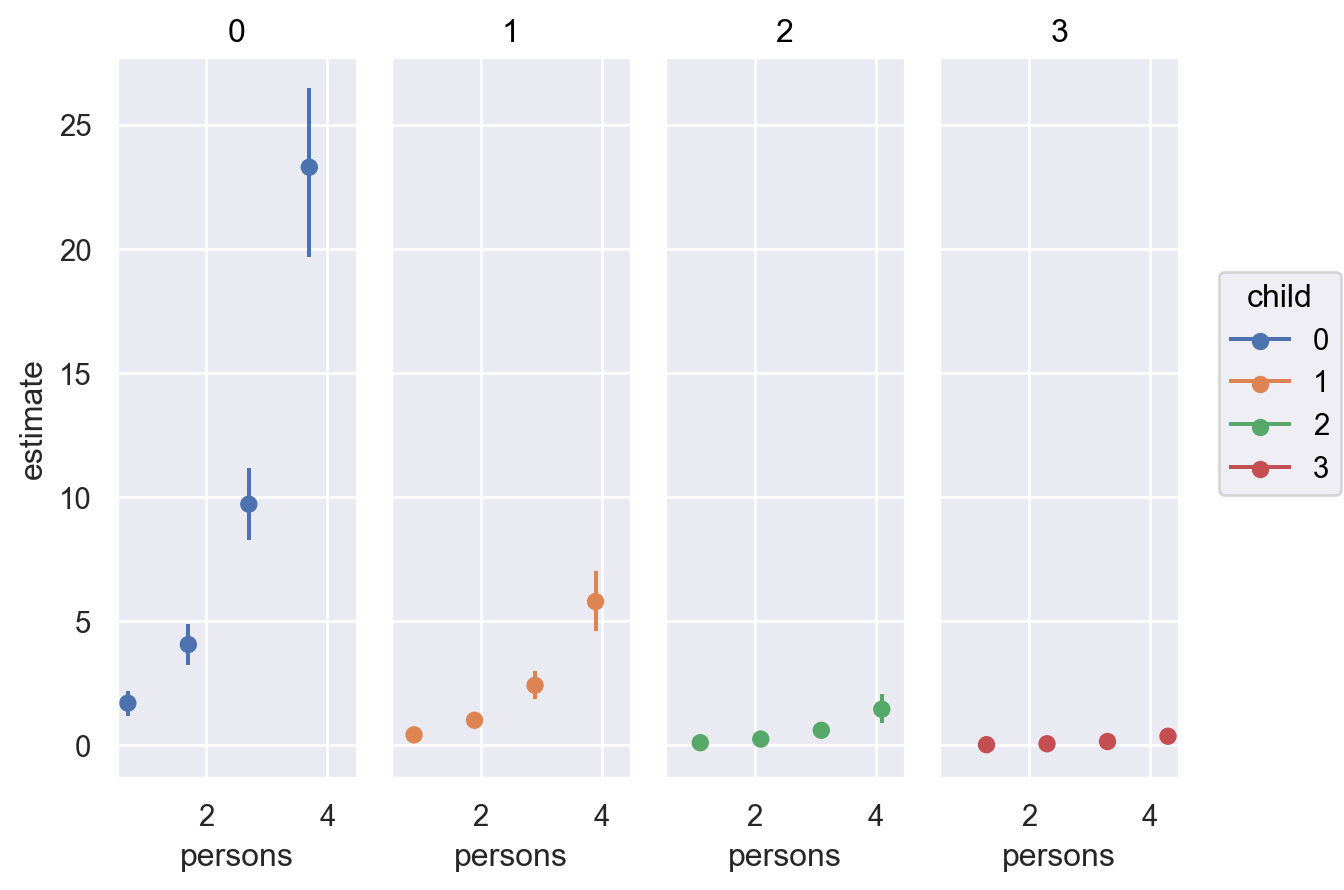

In [9]:
bmb.interpret.plot_comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=["persons", "child"],
    subplot_kwargs={"main": "persons", "group": "child", "panel": "child"},
) 

### Unit level contrasts

Evaluating average predictive comparisons at central values for the conditional covariates $c$ can be problematic when the inputs have a large variance since no single central value (mean, median, etc.) is representative of the covariate. This is especially true when $c$ exhibits bi or multimodality. Thus, it may be desirable to use the empirical distribution of $c$ to compute the predictive comparisons, and then average over a specific or set of covariates to obtain the average predictive comparisons. To achieve unit level contrasts, do not pass a parameter into `conditional` and/or specify `None`.

In [10]:
unit_level = bmb.interpret.comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
)

# empirical distribution
print(unit_level.summary.shape[0] == fish_model.data.shape[0])
unit_level.summary.head(10)

True


,term,estimate_type,camper,child,persons,value,estimate,lower_3.0%,upper_97.0%
0,livebait,diff,0,0,1,0_vs_1,0.866907,0.626193,1.126094
1,livebait,diff,1,0,1,0_vs_1,1.701079,1.277529,2.120203
2,livebait,diff,0,0,1,0_vs_1,0.866907,0.626193,1.126094
3,livebait,diff,1,1,2,0_vs_1,1.011465,0.765103,1.259941
4,livebait,diff,0,0,1,0_vs_1,0.866907,0.626193,1.126094
5,livebait,diff,1,2,4,0_vs_1,1.453594,0.994530,1.976997
6,livebait,diff,0,1,3,0_vs_1,1.233152,0.912043,1.555600
7,livebait,diff,0,3,4,0_vs_1,0.188026,0.093172,0.289529
8,livebait,diff,1,2,3,0_vs_1,0.607238,0.397932,0.817309
9,livebait,diff,1,0,1,0_vs_1,1.701079,1.277529,2.120203


In [11]:
# empirical (observed) data used to fit the model
fish_model.data.head(10)

,count,livebait,camper,persons,child
0,0,0,0,1,0
1,0,1,1,1,0
2,0,1,0,1,0
3,0,1,1,2,1
4,1,1,0,1,0
5,0,1,1,4,2
6,0,1,0,3,1
7,0,1,0,4,3
8,0,0,1,3,2
9,1,1,1,1,0


Above, `unit_level.summary` is the comparisons summary dataframe and `fish_model.data` is the empirical data. Notice how the values for $c$ are identical in both dataframes. However, for $w$, the values are different. However, these unit level contrasts are difficult to interpret as each row corresponds to _that_ unit's contrast. Therefore, it is useful to average over (marginalize) the estimates to summarize the unit level predictive comparisons.

#### Marginalizing over covariates

Since the empirical distrubution is used for computing the average predictive comparisons, the same number of rows (250) is returned as the data used to fit the model. To average over a covariate, use the `average_by` argument. If `all` is passed, then `comparisons` averages over all covariates. Else, if a single or list of covariates are passed, then `comparisons` averages by the covariates passed.

In [12]:
# marginalize over all covariates
bmb.interpret.comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
    average_by="all"
).summary

,term,estimate_type,value,estimate,lower_3.0%,upper_97.0%
0,livebait,diff,0_vs_1,3.652172,2.963445,4.331797


Passing `True` to `average_by` averages over all covariates and is equivalent to taking the mean of the `estimate` and uncertainty columns. For example:

In [13]:
unit_level = bmb.interpret.comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
)

unit_level.summary[["estimate", "lower_3.0%", "upper_97.0%"]].mean()

estimate       3.652172
lower_3.0%     2.963445
upper_97.0%    4.331797
dtype: float64

#### Average by subgroups

Averaging over all covariates may not be desired, and you would rather average by a group or specific covariate. To perform averaging by subgroups, users can pass a single or list of covariates to `average_by` to average over specific covariates. For example, if we wanted to average by `persons`:

In [14]:
# average by number of persons
bmb.interpret.comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
    average_by="persons"
).summary

,term,estimate_type,value,persons,estimate,lower_3.0%,upper_97.0%
0,livebait,diff,0_vs_1,1,1.379118,1.026136,1.736512
1,livebait,diff,0_vs_1,2,1.967518,1.556168,2.392017
2,livebait,diff,0_vs_1,3,3.704838,3.062161,4.358546
3,livebait,diff,0_vs_1,4,7.356535,6.043886,8.607420


In [15]:
# average by number of persons and camper by passing a list
bmb.interpret.comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
    average_by=["persons", "camper"]
).summary

,term,estimate_type,value,persons,camper,estimate,lower_3.0%,upper_97.0%
0,livebait,diff,0_vs_1,1,0,0.866907,0.626193,1.126094
1,livebait,diff,0_vs_1,1,1,1.701079,1.277529,2.120203
2,livebait,diff,0_vs_1,2,0,1.426581,1.089569,1.785491
3,livebait,diff,0_vs_1,2,1,2.350132,1.886202,2.821023
4,livebait,diff,0_vs_1,3,0,2.429426,1.893073,2.970221
5,livebait,diff,0_vs_1,3,1,4.448828,3.744129,5.168402
6,livebait,diff,0_vs_1,4,0,3.537199,2.721745,4.370350
7,livebait,diff,0_vs_1,4,1,10.739376,8.986354,12.360254


It is still possible to use `plot_comparisons` when passing an argument to `average_by`. In the plot below, the empirical distribution is used to compute unit level contrasts for `livebait` and then averaged over `persons` to obtain the average predictive comparisons. The plot below is similar to the second plot in this notebook. The differences being that: (1) a pairwise transition grid is defined for the second plot above, whereas the empirical distribution is used in the plot below, and (2) in the plot below, we marginalized over the other covariates in the model (thus the reason for not having a `camper` or `child` group and panel, and a reduction in the uncertainty interval).

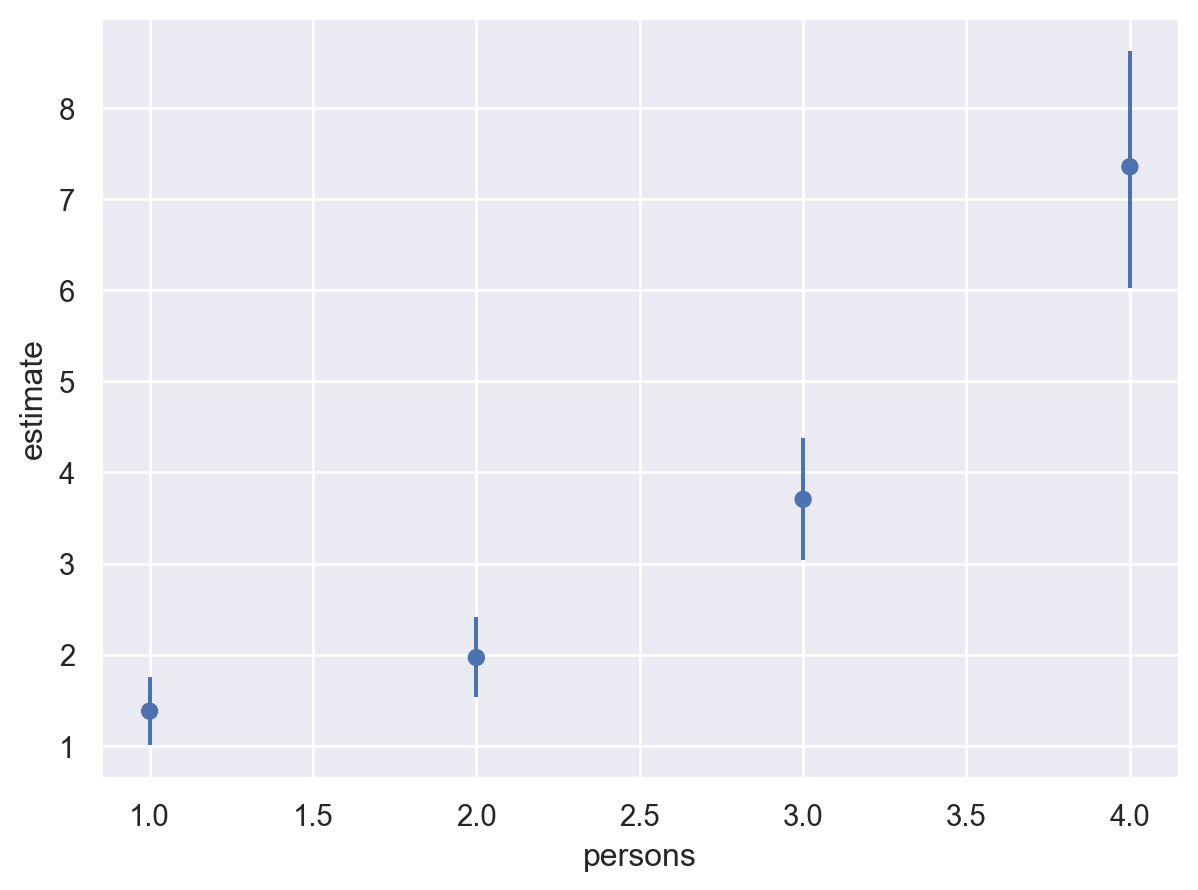

In [16]:
bmb.interpret.plot_comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
    average_by="persons"
)

## Logistic Regression

To showcase an additional functionality of `comparisons` and `plot_comparisons`, we fit a logistic regression model to the [titanic dataset](https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Titanic.csv) with interaction terms to model the probability of survival. The titanic dataset gives the values of four categorical attributes for each of the 2201 people on board the Titanic when it struck an iceberg and sank. The attributes are social class (first class, second class, third class, crewmember), age, sex (0 = female, 1 = male), and whether or not the person survived (0 = deceased, 1 = survived). 

In [17]:
dat = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Titanic.csv", index_col=0)

dat["PClass"] = dat["PClass"].str.replace("[st, nd, rd]", "", regex=True)
dat["PClass"] = dat["PClass"].str.replace("*", "0").astype(int)
dat["PClass"] = dat["PClass"].replace(0, np.nan)
dat["PClass"] = pd.Categorical(dat["PClass"], ordered=True)
dat["SexCode"] = pd.Categorical(dat["SexCode"], ordered=True)

dat = dat.dropna(axis=0, how="any")

In [18]:
titanic_model = bmb.Model(
    "Survived ~ PClass * SexCode * Age",
    data=dat,
    family="bernoulli"
)
titanic_idata = titanic_model.fit(
    draws=500,
    tune=500,
    target_accept=0.95,
    random_seed=1234
)

Modeling the probability that Survived==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, PClass, SexCode, PClass:SexCode, Age, PClass:Age, SexCode:Age, PClass:SexCode:Age]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


### Comparison types

`comparisons` and `plot_comparisons` also allow you to specify the type of comparison to be computed. By default, a difference is used. However, it is also possible to take the ratio where comparisons would then become _average predictive ratios_. To achieve this, pass `"ratio"` into the argument `comparison`. Using different comparison types offers a way to produce alternative insights; especially when there are interaction terms as the value of one covariate depends on the value of the other covariate.

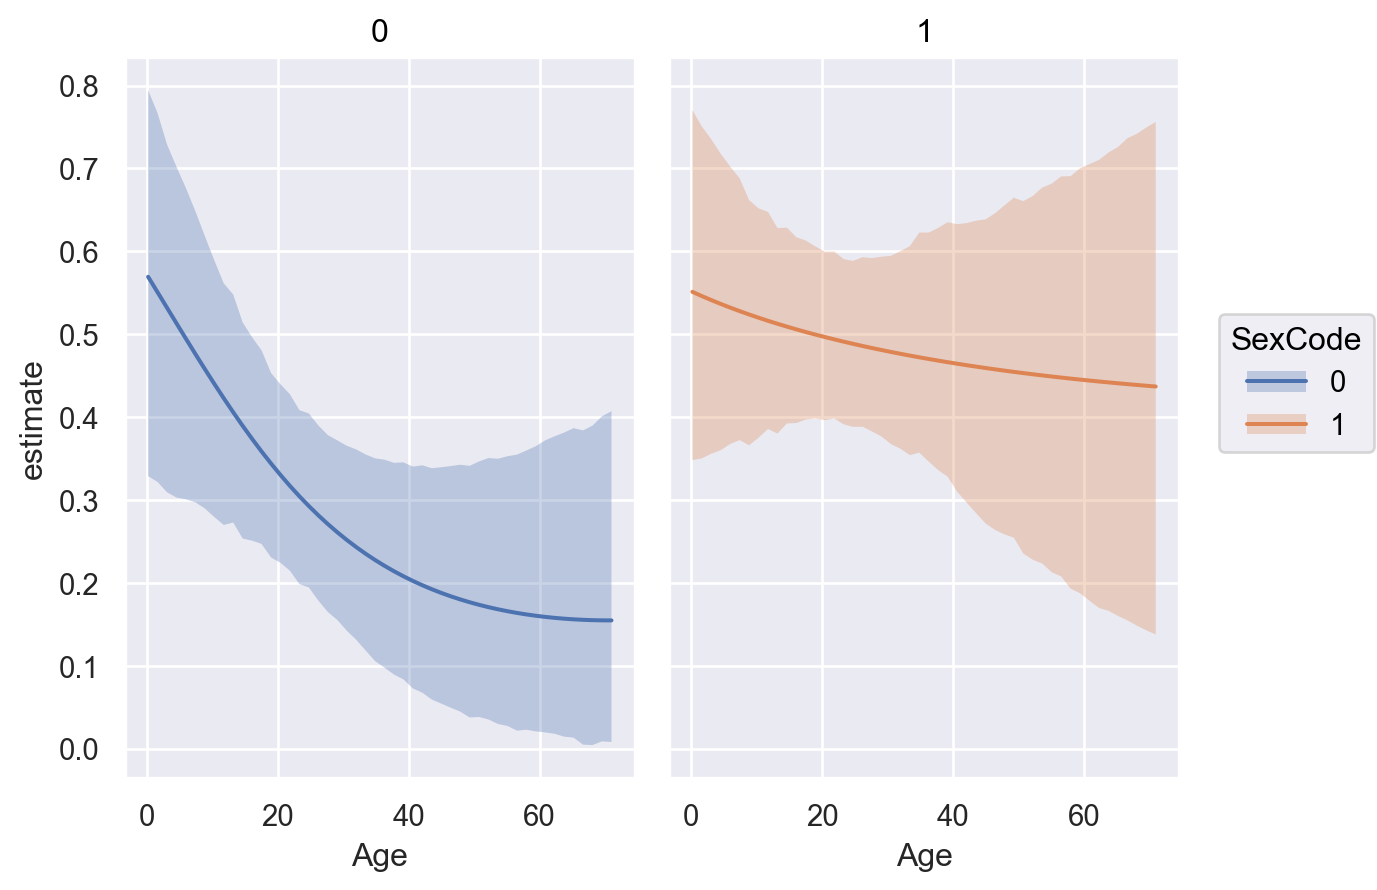

In [19]:
bmb.interpret.plot_comparisons(
    model=titanic_model,
    idata=titanic_idata,
    contrast={"PClass": [1, 3]},
    conditional=["Age", "SexCode"],
    comparison="ratio",
    subplot_kwargs={"main": "Age", "group": "SexCode", "panel": "SexCode"},
)

The left panel shows that the ratio of the probability of survival comparing `PClass` $3$ to $1$ conditional on `Age` is non-constant. Whereas the right panel shows an approximately constant ratio in the probability of survival comparing `PClass` $3$ to $1$ conditional on `Age`. 

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue, 17 Feb 2026

Python implementation: CPython
Python version       : 3.13.12
IPython version      : 9.10.0

arviz : 0.23.4
bambi : 0.1.dev890+g3e105f2cc.d20260217
numpy : 2.3.5
pandas: 2.3.3

Watermark: 2.6.0

